# Compressor de Imagens

### Inicialização de bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import fftpack
import matplotlib.image as mpimg
from collections import Counter

### Funções Auxiliares

In [2]:
def get_2d_dct(img):
    """ Get 2D Cosine Transform of Image
    """
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

def calcEntropy(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()
    logs = np.log2(hist+0.00001)
    entropy = -1 * (hist*logs).sum()

    return entropy

def calcEntropyList(list):

    dictionary = {}

    for i in list:
        if dictionary.get(i) == None:
            dictionary[i] = 1
        else:
            dictionary[i] = dictionary[i]+1

    for key in dictionary:
        dictionary[key] = dictionary[key]/len(aux)
    
    values = dictionary.values()

    return -sum(map(lambda x: x*np.log2(x), values))

### Matriz de Quantização

In [3]:
# aplicação da tabela de quantização
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# quantization matrix
QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

QM = QM.astype(float)

### Funções principais

In [6]:
def dct(img_path):
    img = cv2.imread(img_path, 0)
    img = img.astype(float)
    step = 8
    size = img.shape
    
    DCT = np.zeros(img.shape, dtype=np.float)
    DC = np.zeros((img.shape[0]//8, img.shape[1]//8), dtype=np.float)
    
    img = img-128
    
    for y in range(0,size[0],step):
        for x in range(0,size[1],step):
            dct = get_2d_dct(img[y:y+step, x:x+step])
            DC[y//8, x//8] = dct[0,0]
            dct = np.divide(dct, QM)
            dct = dct.round()
            DCT[y:y+step, x:x+step] = dct
    
    return img+128, DCT, DC

def idct(DCT, DC):
    size = DCT.shape
    step = 8
    IDCT = np.zeros(img.shape, dtype=np.float)
    
    for y in range(0,size[0],step):
        for x in range(0,size[1],step):
            dct = np.multiply(DCT[y:y+step, x:x+step], QM)
#             dct[0,0] = DC[y//8, x//8]
            IDCT[y:y+step, x:x+step] = get_2d_idct(dct)

    IDCT = IDCT + 128
    
    return IDCT

def zigzag(DCT):
    step = 8
    
    vector = []

    for x in range(0, DCT.shape[0], step):
        for y in range(0, DCT.shape[1], step):
            local = DCT[x:x+8, y:y+8]

            (i,j) = (0,0)

            while i < 8 and j < 8:
                vector.append(int(local[i,j]))
                # subida
                if (i+j)%2 == 0:
                    # borda esquerda da matriz
                    if j == 7:
                        i = i+1
                        continue
                    # borda superior da matriz
                    if i == 0:
                        j = j+1
                        continue
                    i = i-1
                    j = j+1

                #descida
                else:
                    # borda inferior da matriz
                    if i == 7:
                        j = j+1
                        continue
                    # borda direita da matriz
                    if j == 0:
                        i = i+1
                        continue
                    i = i+1
                    j = j-1
    
    return vector, DCT.shape

def DeZigZag(vector, shape):
    
    step = 8
    reconstruct = np.zeros(shape, dtype=np.float64)
    index = 0

    for x in range(0, shape[0], step):
        for y in range(0, shape[1], step):

            (i,j) = (0,0)

            while i < 8 and j < 8:
                reconstruct[x+i,y+j] = vector[index]
                index = index+1
                # subida
                if (i+j)%2 == 0:
                    # borda esquerda da matriz
                    if j == 7:
                        i = i+1
                        continue
                    # borda superior da matriz
                    if i == 0:
                        j = j+1
                        continue
                    i = i-1
                    j = j+1

                #descida
                else:
                    # borda inferior da matriz
                    if i == 7:
                        j = j+1
                        continue
                    # borda direita da matriz
                    if j == 0:
                        i = i+1
                        continue
                    i = i+1
                    j = j-1

    return reconstruct

def lossless_predictive(vector):
    aux = [vector[0]]
    
    for i in range(1, len(vector)):
        aux.append(vector[i] - vector[i-1])
    
    return aux

def undo_lossless_predictive(vector):
    reconstruct = [vector[0]]
    
    for i in range(1,len(vector)):
        reconstruct.append(reconstruct[-1]+vector[i])
        
    return reconstruct

def huffman(DCT, DC):
    return None

def decode(coded_file):
    return DCT, DC

### Implementação

/tmp/ipykernel_841/2404495738.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  DCT = np.zeros(img.shape, dtype=np.float)
/tmp/ipykernel_841/2404495738.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  DC = np.zeros((img.shape[0]//8, img.shape[1]//8), dtype=np.float)
/tmp/ipykernel_841/2404495738.py:25: DeprecationWarning: `np.float` 

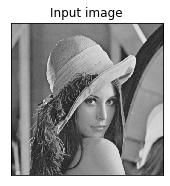

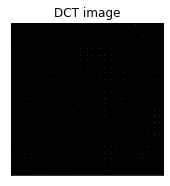

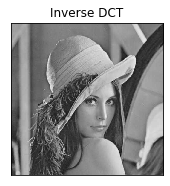

RMSE: 4.133
PSNR: 35.805


In [7]:
img, DCT, DC = dct('lena512.pgm')
vector, shape = zigzag(DCT)
predictive = lossless_predictive(DCT)
after_prediction = undo_lossless_predictive(predictive)
DCT = DeZigZag(vector, shape)
IDCT = idct(DCT, DC)
        
plt.subplot(121),plt.imshow(img, cmap = 'gray', clim=(0, 255))
plt.title('Input image'), plt.xticks([]), plt.yticks([])
plt.show()

plt.subplot(121),plt.imshow(DCT, cmap = 'gray', clim=(0, 255))
plt.title('DCT image'), plt.xticks([]), plt.yticks([])
plt.show()

plt.subplot(121),plt.imshow(IDCT, cmap = 'gray', clim=(0, 255))
plt.title('Inverse DCT'), plt.xticks([]), plt.yticks([])
plt.show()

print ("RMSE: %5.3f" % rmse(img, IDCT))
print ("PSNR: %5.3f" % psnr(img, IDCT))